<a href="https://colab.research.google.com/github/rrankawat/pytorch-cnn/blob/main/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Import Libraries

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import time

##### Data Loading & Converting To Batches

In [59]:
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [81]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

##### CNN Model

In [61]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    # First Pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-view to flatten it out
    X = X.view(-1, 16 * 5 * 5)

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

##### Random Seeds and Model Instance

In [62]:
torch.manual_seed(41)
model = ConvolutionalNetwork()

##### Loss & Optimizer

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### Time Function

In [64]:
def totalTime(start_time):
  current_time = time.time()
  total_time = (current_time - start_time) / 60
  return round(total_time, 2)

##### Model Training & Testing

In [65]:
# Variables to track things
epochs = 5
train_losses = []
train_correct = []
test_losses = []
test_correct = []

In [66]:
# -------------------
# Training function
# -------------------
def train(epoch, model, train_loader, criterion, optimizer):
  model.train()

  trn_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    trn_corr += (predicted == y_train).sum()

    # Back-propagation & Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b % 600 == 0:
      print(f"Epoch: {epoch + 1} [{b * len(X_train)}/{len(train_loader.dataset)} "
            f"({100. * b / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

  print("\n")
  train_losses.append(loss)
  train_correct.append(trn_corr)

In [67]:
# -------------------
# Test function
# -------------------
def test(model, test_loader, criterion, optimizer):
  model.eval()
  tst_corr = 0

  with torch.no_grad():
    for X_test, y_test in test_loader:
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

In [68]:
start_time = time.time()

# Loop through the epochs
for epoch in range(epochs):
  train(epoch, model, train_loader, criterion, optimizer)
  test(model, test_loader, criterion, optimizer)

print(f'Time taken: {totalTime(start_time)} minutes!')

Epoch: 1 [6000/60000 (10%)]	Loss: 0.626664
Epoch: 1 [12000/60000 (20%)]	Loss: 0.351763
Epoch: 1 [18000/60000 (30%)]	Loss: 0.139812
Epoch: 1 [24000/60000 (40%)]	Loss: 0.439566
Epoch: 1 [30000/60000 (50%)]	Loss: 0.417436
Epoch: 1 [36000/60000 (60%)]	Loss: 0.505042
Epoch: 1 [42000/60000 (70%)]	Loss: 0.432231
Epoch: 1 [48000/60000 (80%)]	Loss: 0.410335
Epoch: 1 [54000/60000 (90%)]	Loss: 0.060237
Epoch: 1 [60000/60000 (100%)]	Loss: 0.439208


Epoch: 2 [6000/60000 (10%)]	Loss: 0.109809
Epoch: 2 [12000/60000 (20%)]	Loss: 0.280083
Epoch: 2 [18000/60000 (30%)]	Loss: 0.491054
Epoch: 2 [24000/60000 (40%)]	Loss: 0.230650
Epoch: 2 [30000/60000 (50%)]	Loss: 0.125036
Epoch: 2 [36000/60000 (60%)]	Loss: 0.293542
Epoch: 2 [42000/60000 (70%)]	Loss: 0.436008
Epoch: 2 [48000/60000 (80%)]	Loss: 0.050899
Epoch: 2 [54000/60000 (90%)]	Loss: 0.232114
Epoch: 2 [60000/60000 (100%)]	Loss: 1.142078


Epoch: 3 [6000/60000 (10%)]	Loss: 0.064980
Epoch: 3 [12000/60000 (20%)]	Loss: 0.497171
Epoch: 3 [18000/60000 (30%)]	

##### Plots

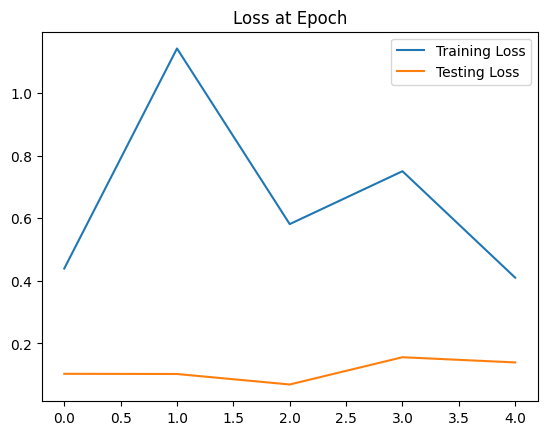

In [69]:
# ------------------------
# Plot the loss at each Epoch
# ------------------------
plt.plot([loss.detach().numpy() for loss in train_losses], label='Training Loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

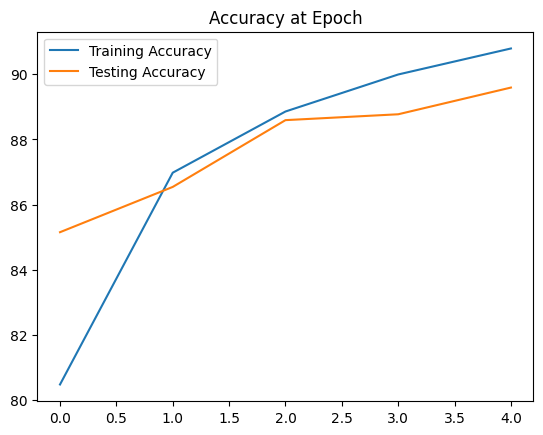

In [70]:
# --------------------------------------------
# Plot the accuracy at the end of each Epoch
# --------------------------------------------
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

##### Test Accuracy

In [71]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [72]:
# Test for correct
correct.item() / len(test_data) * 100
print(f'Test Accuracy: {round(correct.item()/len(test_data) * 100, 2)}%')

Test Accuracy: 89.59%


##### Test on New Images

In [73]:
# Taking an Test Image 1
test_image1 = test_data[4133][0]

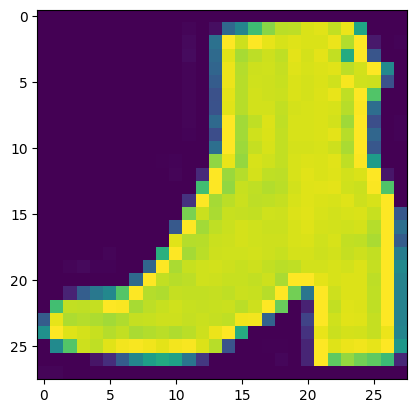

In [74]:
plt.imshow(test_image1.reshape(28, 28))

In [75]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output = model(test_image1.view(1, 1, 28, 28))

In [82]:
# Check the new prediction
classes[output.argmax()]

'Ankle Boot'

In [77]:
# Taking an Test Image 2
test_image2 = test_data[1473][0]

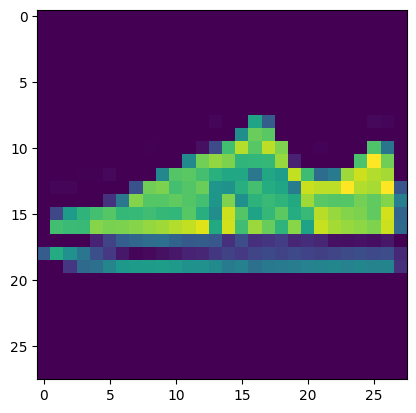

In [78]:
plt.imshow(test_image2.reshape(28, 28))

In [79]:
# Another Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output2 = model(test_image2.view(1, 1, 28, 28))

In [83]:
# Check the new prediction
classes[output2.argmax()]

'Sneaker'